# Understanding GLASSES

 In this notebook I am trying to understand two main things:

* If using the batch selection criterion of the paper with Neil and Philipp makes sense to predict future locations of the algorithm (as an alternative to using dpp samples).
* How the loss function evolves when we start looking further and further.

In [1]:
import GPyOptmsa
import GPyOpt 
import GPy
import numpy as np
from numpy.random import seed
from GPyOpt.core.optimization import wrapper_lbfgsb, wrapper_DIRECT, estimate_L, estimate_Min
from GPyOptmsa.util.general import samples_multidimensional_uniform, multigrid
from GPyOptmsa.util.acquisition import predict_locations
import matplotlib.pyplot as plt
%matplotlib inline

## Problem definition and GP model

In [2]:
# --- Objective function. Will work as a illustration of the loss function we are using
objective_true  = GPyOpt.fmodels.experiments2d.sixhumpcamel()             # true function
objective_noisy = GPyOpt.fmodels.experiments2d.sixhumpcamel(sd = 0.1)     # noisy version
bounds = objective_noisy.bounds                                           # problem constrains 
input_dim = len(bounds)
f = objective_noisy.f 

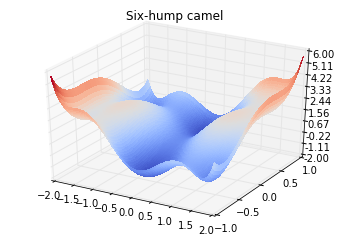

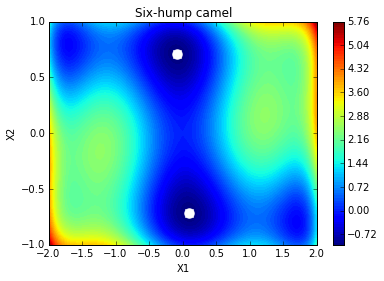

In [3]:
objective_true.plot() 

In [3]:
## set initial points
seed(12345)
X = samples_multidimensional_uniform(bounds,10)
Y = f(X)

In [4]:
## Create a GpyOpt object with loss function 
BO_glasses = GPyOptmsa.msa.GLASSES(f,bounds, X, Y, n_ahead = 5)   

Optimization restart 1/5, f = 14.9428905667
Optimization restart 2/5, f = 15.4784306847
Optimization restart 3/5, f = 15.478430894
Optimization restart 4/5, f = 15.4784308941
Optimization restart 5/5, f = 15.4784308905


{'contour': <matplotlib.contour.QuadContourSet instance at 0x7f1f51c6be60>,
 'dataplot': <matplotlib.collections.PathCollection at 0x7f1f51bc77d0>}

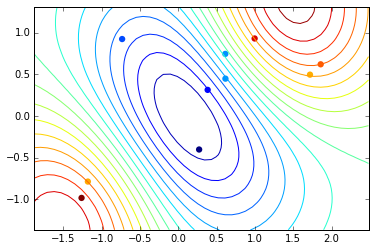

In [5]:
# This is the GP model that we have obtained.
BO_glasses.model.plot()

In [6]:
# Plot myopic loss function
n_grid = 15
X1 = np.linspace(bounds[0][0], bounds[0][1], n_grid)
X2 = np.linspace(bounds[1][0], bounds[1][1], n_grid)
x1, x2 = np.meshgrid(X1, X2)
X = np.hstack((x1.reshape(n_grid*n_grid,1),x2.reshape(n_grid*n_grid,1)))

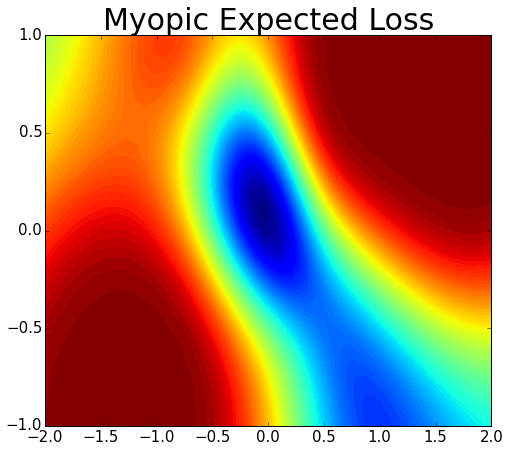

In [8]:
plt.figure(figsize=(8,7))            
plt.contourf(X1, X2, BO_glasses.loss.acquisition_function(X).reshape((n_grid,n_grid)),100)
#plt.plot(BO_glasses.model.X[:,0], BO_glasses.model.X[:,1], 'r.', markersize=20, label=u'Observations')
#plt.colorbar()  
#plt.xlabel('X1',fontsize=20)
#plt.ylabel('X2',fontsize=20)            
plt.title('Myopic Expected Loss',size=30)
plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))
plt.tick_params(axis='both', which='major', labelsize=15)
#plt.legend()
plt.savefig('bo_1step.pdf',type='pdf',bbox_inches='tight', pad_inches=0.1)

## Predicting the future steps of the algorithm

Ok, so we have the myopic loss function above. Now, we assume that we want to predict the future steps of the algorithm 5 steps ahead. To do this, we select one putative location (where the non-myopic loss will be evaluated) and we predict 4 more steps of the algorithm. The details of how the locations are obtained are in the paper I sent you. We have found that it woks very well finding good batches of points and it is fast to compute. Essentially, the method explore the modes of the acquisition defining exclusion zones around already visited locations (some sort of 'fast-greedy' dpp MAP) 

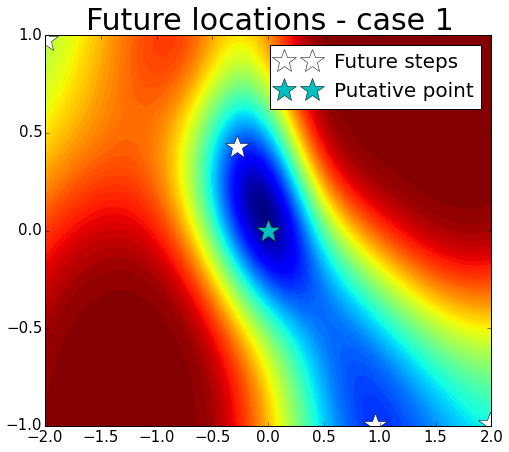

In [10]:
# Miopic loss function plus predicted locations starting at [0,0]

# set-up
x_star = np.array([0,0])

expected_loss = BO_glasses.loss
model = BO_glasses.model
L = estimate_L(model,bounds)
Min =estimate_Min(model,bounds)
n_ahead = 5

# predict the locations with the batch method
predicted_locations = predict_locations(x_star, bounds, expected_loss, n_ahead, L, Min, model)

# make the plot
plt.figure(figsize=(8,7))   
plt.title('Future locations - case 1',size=30)
plt.contourf(X1, X2, BO_glasses.loss.acquisition_function(X).reshape((n_grid,n_grid)),100)
#plt.plot(BO_glasses.model.X[:,0], BO_glasses.model.X[:,1], 'r.', markersize=20, label=u'Observations')
plt.plot(predicted_locations[:,0], predicted_locations[:,1], 'w*', markersize=25, label=u'Future steps')
plt.plot(predicted_locations[0,0], predicted_locations[0,1], 'c*', markersize=25, label=u'Putative point')
plt.legend(loc=1, fontsize=20)

#plt.xlabel('X1', fontsize=20)
#plt.ylabel('X2', fontsize=20)            
#plt.title('Myopic - expected loss 1 step ahead',size=20)
plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))
plt.tick_params(axis='both', which='major', labelsize=15)
#plt.legend()
plt.savefig('predicted_locations1.pdf',type='pdf',bbox_inches='tight', pad_inches=0.1)

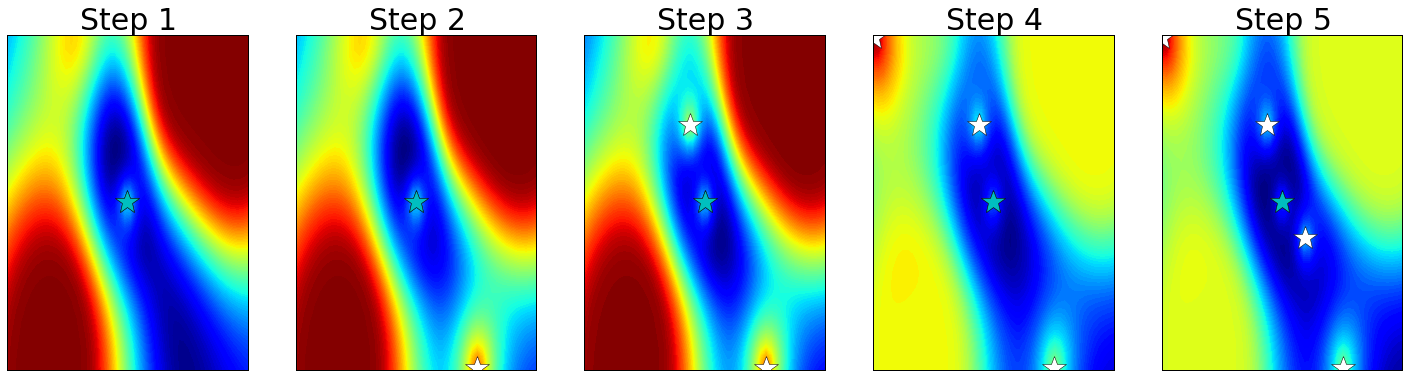

In [134]:
from GPyOpt.core.acquisition import AcquisitionMP

plt.figure(figsize=(25,6))



## 1
plt.subplot(151)
pred_locations = predicted_locations[0:1,:]
pen = AcquisitionMP(BO_glasses.loss,transform = "none")
pen.X_batch = pred_locations
pen.model = BO_glasses.model
pen.update_batches(pred_locations,L,Min)
pen.acq = BO_glasses.loss
pen.r_x0
plt.contourf(X1, X2, pen.acquisition_function(X).reshape((n_grid,n_grid)),100)
plt.title('Step 1',size=30)
plt.plot(pred_locations[:,0], pred_locations[:,1], 'w*', markersize=25, label=u'Future steps')
plt.plot(pred_locations[0,0], pred_locations[0,1], 'c*', markersize=25, label=u'Putative point')
plt.xticks([])
plt.yticks([])

## 1
plt.subplot(152)
pred_locations = predicted_locations[0:2,:]
pen = AcquisitionMP(BO_glasses.loss,transform = "none")
pen.X_batch = pred_locations
pen.model = BO_glasses.model
pen.update_batches(pred_locations,L,Min)
pen.acq = BO_glasses.loss
pen.r_x0
plt.contourf(X1, X2, pen.acquisition_function(X).reshape((n_grid,n_grid)),100)
plt.title('Step 2',size=30)
plt.plot(pred_locations[:,0], pred_locations[:,1], 'w*', markersize=25, label=u'Future steps')
plt.plot(pred_locations[0,0], pred_locations[0,1], 'c*', markersize=25, label=u'Putative point')
plt.xticks([])
plt.yticks([])

## 1
plt.subplot(153)
pred_locations = predicted_locations[0:3,:]
pen = AcquisitionMP(BO_glasses.loss,transform = "none")
pen.X_batch = pred_locations
pen.model = BO_glasses.model
pen.update_batches(pred_locations,L,Min)
pen.acq = BO_glasses.loss
pen.r_x0
plt.contourf(X1, X2, pen.acquisition_function(X).reshape((n_grid,n_grid)),100)
plt.title('Step 3',size=30)
plt.plot(pred_locations[:,0], pred_locations[:,1], 'w*', markersize=25, label=u'Future steps')
plt.plot(pred_locations[0,0], pred_locations[0,1], 'c*', markersize=25, label=u'Putative point')
plt.xticks([])
plt.yticks([])

## 1
plt.subplot(154)
pred_locations = predicted_locations[0:4,:]
pen = AcquisitionMP(BO_glasses.loss,transform = "none")
pen.X_batch = pred_locations
pen.model = BO_glasses.model
pen.update_batches(pred_locations,L,Min)
pen.acq = BO_glasses.loss
pen.r_x0
plt.contourf(X1, X2, pen.acquisition_function(X).reshape((n_grid,n_grid)),100)
plt.title('Step 4',size=30)
plt.plot(pred_locations[:,0], pred_locations[:,1], 'w*', markersize=25, label=u'Future steps')
plt.plot(pred_locations[0,0], pred_locations[0,1], 'c*', markersize=25, label=u'Putative point')
plt.xticks([])
plt.yticks([])

## 1
plt.subplot(155)
pred_locations = predicted_locations[0:5,:]
pen = AcquisitionMP(BO_glasses.loss,transform = "none")
pen.X_batch = pred_locations
pen.model = BO_glasses.model
pen.update_batches(pred_locations,L,Min)
pen.acq = BO_glasses.loss
pen.r_x0
plt.contourf(X1, X2, pen.acquisition_function(X).reshape((n_grid,n_grid)),100)
plt.title('Step 5',size=30)
plt.plot(pred_locations[:,0], pred_locations[:,1], 'w*', markersize=25, label=u'Future steps')
plt.plot(pred_locations[0,0], pred_locations[0,1], 'c*', markersize=25, label=u'Putative point')
plt.xticks([])
plt.yticks([])

plt.savefig('steps.pdf',type='pdf',bbox_inches='tight', pad_inches=0.1)

In [119]:
aq.ac

AttributeError: 'AcquisitionMP' object has no attribute 'ac'

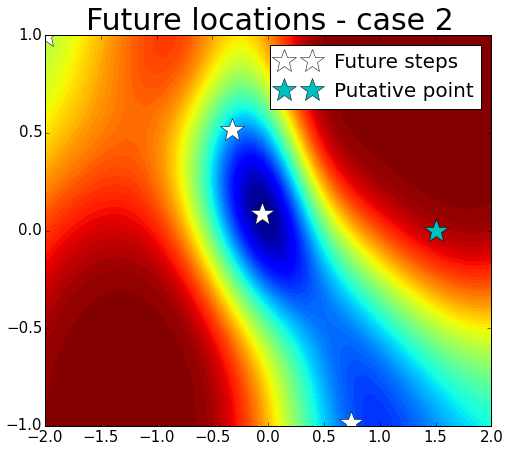

In [115]:
# Miopic loss fucntion plus predicted locations starting at [1.5,0]

# set-up
x_star = np.array([1.5,0])

expected_loss = BO_glasses.loss
model = BO_glasses.model
L = estimate_L(model,bounds)
Min =estimate_Min(model,bounds)
n_ahead = 5

# predict the locations with the batch method
predicted_locations = predict_locations(x_star, bounds, expected_loss, n_ahead, L, Min, model)

# make the plot
plt.figure(figsize=(8,7))            
plt.contourf(X1, X2, BO_glasses.loss.acquisition_function(X).reshape((n_grid,n_grid)),100)
#plt.plot(BO_glasses.model.X[:,0], BO_glasses.model.X[:,1], 'r.', markersize=20, label=u'Observations')
plt.plot(predicted_locations[:,0], predicted_locations[:,1], 'w*', markersize=25, label=u'Future steps')
plt.plot(predicted_locations[0,0], predicted_locations[0,1], 'c*', markersize=25, label=u'Putative point')
plt.legend(loc=1, fontsize=20)

#plt.xlabel('X1')
#plt.ylabel('X2')            
plt.title('Future locations - case 2',size=30)
plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))
plt.tick_params(axis='both', which='major', labelsize=15)
#plt.legend()
plt.savefig('predicted_locations2.pdf',type='pdf',bbox_inches='tight', pad_inches=0.1)


<matplotlib.colorbar.Colorbar instance at 0xd97e830>

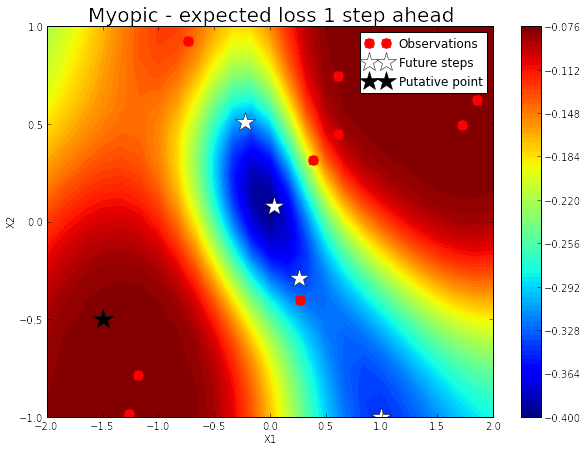

In [46]:
# Miopic loss function plus predicted locations starting at [-1.5,-0.5]

# set-up
x_star = np.array([-1.5,-0.5])

expected_loss = BO_glasses.loss
model = BO_glasses.model
L = estimate_L(model,bounds)
Min =estimate_Min(model,bounds)
n_ahead = 5

# predict the locations with the batch method
predicted_locations = predict_locations(x_star, bounds, expected_loss, n_ahead, L, Min, model)

# make the plot
plt.figure(figsize=(10,7))            
plt.contourf(X1, X2, BO_glasses.loss.acquisition_function(X).reshape((n_grid,n_grid)),100)
plt.plot(BO_glasses.model.X[:,0], BO_glasses.model.X[:,1], 'r.', markersize=20, label=u'Observations')
plt.plot(predicted_locations[:,0], predicted_locations[:,1], 'w*', markersize=20, label=u'Future steps')
plt.plot(predicted_locations[0,0], predicted_locations[0,1], 'k*', markersize=20, label=u'Putative point')
plt.legend()

plt.xlabel('X1')
plt.ylabel('X2')            
plt.title('Myopic - expected loss 1 step ahead',size=20)
plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))
plt.colorbar()  


<matplotlib.colorbar.Colorbar instance at 0xdf71f80>

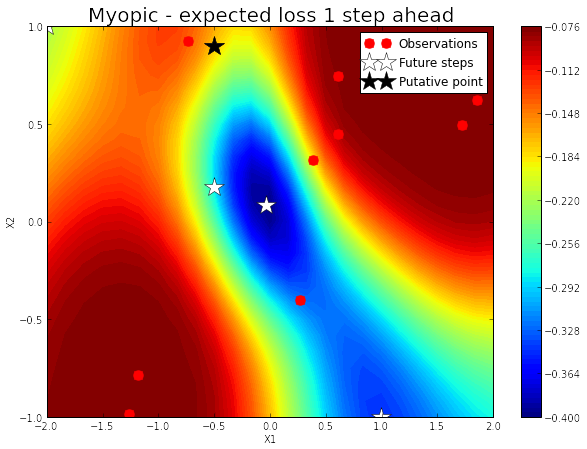

In [47]:
# Miopic loss function plus predicted locations starting at [-0.5,0.9]

# set-up
x_star = np.array([-0.5,0.9])

expected_loss = BO_glasses.loss
model = BO_glasses.model
L = estimate_L(model,bounds)
Min =estimate_Min(model,bounds)
n_ahead = 5

# predict the locations with the batch method
predicted_locations = predict_locations(x_star, bounds, expected_loss, n_ahead, L, Min, model)

# make the plot
plt.figure(figsize=(10,7))            
plt.contourf(X1, X2, BO_glasses.loss.acquisition_function(X).reshape((n_grid,n_grid)),100)
plt.plot(BO_glasses.model.X[:,0], BO_glasses.model.X[:,1], 'r.', markersize=20, label=u'Observations')
plt.plot(predicted_locations[:,0], predicted_locations[:,1], 'w*', markersize=20, label=u'Future steps')
plt.plot(predicted_locations[0,0], predicted_locations[0,1], 'k*', markersize=20, label=u'Putative point')
plt.legend()

plt.xlabel('X1')
plt.ylabel('X2')            
plt.title('Myopic - expected loss 1 step ahead',size=20)
plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))
plt.colorbar()  


<matplotlib.colorbar.Colorbar instance at 0xe450710>

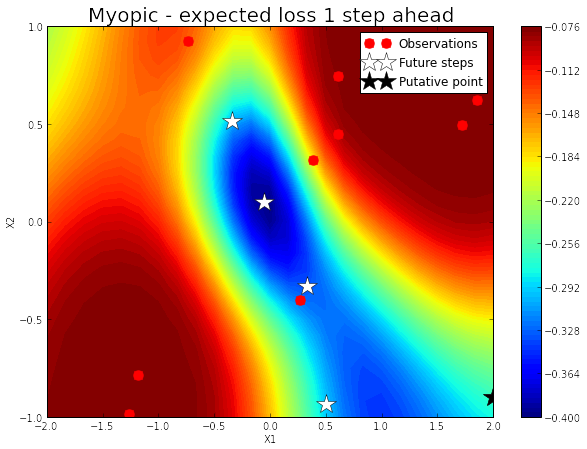

In [48]:
# Miopic loss function plus predicted locations starting at [2,-0.9]

# set-up
x_star = np.array([2,-0.9])

expected_loss = BO_glasses.loss
model = BO_glasses.model
L = estimate_L(model,bounds)
Min =estimate_Min(model,bounds)
n_ahead = 5

# predict the locations with the batch method
predicted_locations = predict_locations(x_star, bounds, expected_loss, n_ahead, L, Min, model)

# make the plot
plt.figure(figsize=(10,7))            
plt.contourf(X1, X2, BO_glasses.loss.acquisition_function(X).reshape((n_grid,n_grid)),100)
plt.plot(BO_glasses.model.X[:,0], BO_glasses.model.X[:,1], 'r.', markersize=20, label=u'Observations')
plt.plot(predicted_locations[:,0], predicted_locations[:,1], 'w*', markersize=20, label=u'Future steps')
plt.plot(predicted_locations[0,0], predicted_locations[0,1], 'k*', markersize=20, label=u'Putative point')
plt.legend()

plt.xlabel('X1')
plt.ylabel('X2')            
plt.title('Myopic - expected loss 1 step ahead',size=20)
plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))
plt.colorbar()  

What the algorithm does makes sense to me: when the putative input is in a 'bad' location the steps ahead correspond to the modes of the acquisition. When the putative input is already in a mode, it keeps exploring new ones.

## Non-myopic loss function for different number of steps ahead

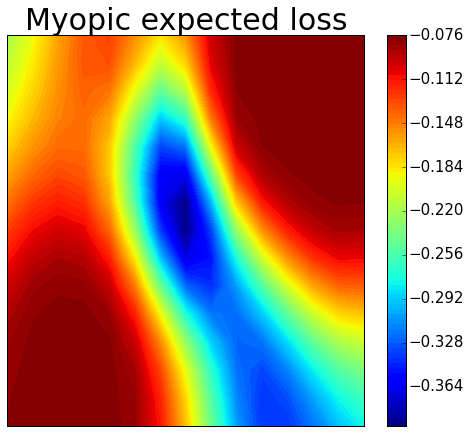

In [9]:
plt.figure(figsize=(8,7))            
plt.contourf(X1, X2, BO_glasses.loss.acquisition_function(X).reshape((n_grid,n_grid)),100)
#plt.plot(BO_glasses.model.X[:,0], BO_glasses.model.X[:,1], 'r.', markersize=20, label=u'Observations')
#plt.colorbar()  
#plt.xlabel('X1',fontsize=20)
#plt.ylabel('X2',fontsize=20)            
plt.title('Myopic expected loss',size=30)
plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))
plt.tick_params(axis='both', which='major', labelsize=15)
cbar = plt.colorbar()
cbar.ax.tick_params(axis='both', which='major', labelsize=15)
plt.xticks([])
plt.yticks([])
plt.savefig('1_ahead.pdf',type='pdf',bbox_inches='tight', pad_inches=0.1)


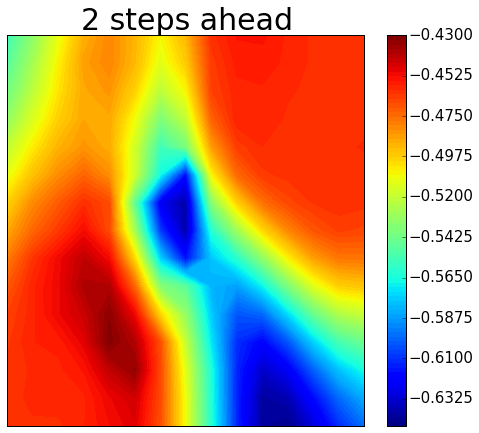

In [47]:
## 2 steps ahead
#BO_glasses.n_ahead = 2
#loss_ahead2 = BO_glasses.loss_ahead(X).reshape((n_grid,n_grid))

# make the plot
plt.figure(figsize=(8,7))            
plt.contourf(X1, X2,loss_ahead2,100)
#plt.plot(BO_glasses.model.X[:,0], BO_glasses.model.X[:,1], 'r.', markersize=20, label=u'Observations')
#plt.legend()
#plt.xlabel('X1')
#plt.ylabel('X2')            
plt.title('2 steps ahead',size=30)
plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))
plt.tick_params(axis='both', which='major', labelsize=15)
cbar = plt.colorbar()
cbar.ax.tick_params(axis='both', which='major', labelsize=15)
plt.xticks([])
plt.yticks([])
plt.savefig('2_ahead.pdf',type='pdf',bbox_inches='tight', pad_inches=0.1)

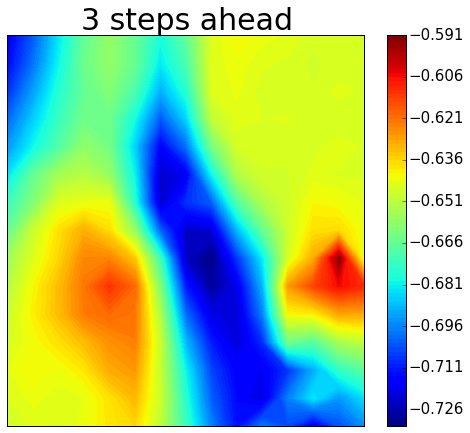

In [49]:
## 3 steps ahead
BO_glasses.n_ahead = 3
loss_ahead2 = BO_glasses.loss_ahead(X).reshape((n_grid,n_grid))

# make the plot
plt.figure(figsize=(8,7))            
plt.contourf(X1, X2,loss_ahead2,100)
#plt.plot(BO_glasses.model.X[:,0], BO_glasses.model.X[:,1], 'r.', markersize=20, label=u'Observations')
#plt.legend()
#plt.xlabel('X1')
#plt.ylabel('X2')            
plt.title('3 steps ahead',size=30)
plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))
plt.tick_params(axis='both', which='major', labelsize=15)
cbar = plt.colorbar()
cbar.ax.tick_params(axis='both', which='major', labelsize=15)
plt.xticks([])
plt.yticks([])
plt.savefig('3_ahead.pdf',type='pdf',bbox_inches='tight', pad_inches=0.1)

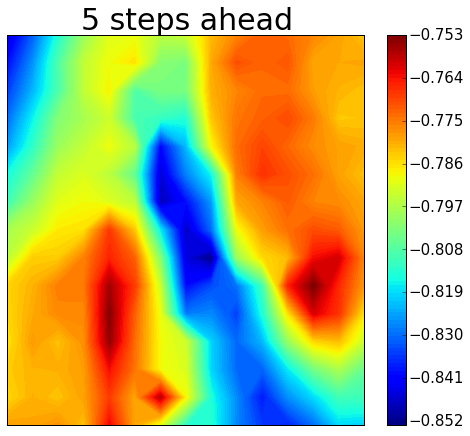

In [7]:
## 5 steps ahead
BO_glasses.n_ahead = 5
loss_ahead2 = BO_glasses.loss_ahead(X).reshape((n_grid,n_grid))

# make the plot
plt.figure(figsize=(8,7))            
plt.contourf(X1, X2,loss_ahead2,100)
#plt.plot(BO_glasses.model.X[:,0], BO_glasses.model.X[:,1], 'r.', markersize=20, label=u'Observations')
#plt.legend()
#plt.xlabel('X1')
#plt.ylabel('X2')            
plt.title('5 steps ahead',size=30)
plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))
plt.tick_params(axis='both', which='major', labelsize=15)
cbar = plt.colorbar()
cbar.ax.tick_params(axis='both', which='major', labelsize=15)
plt.xticks([])
plt.yticks([])
plt.savefig('5_ahead.pdf',type='pdf',bbox_inches='tight', pad_inches=0.1)

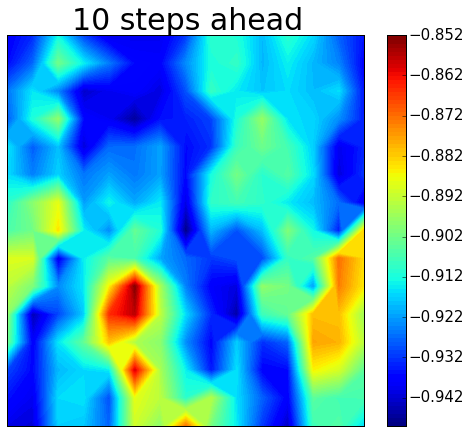

In [52]:
## 5 steps ahead
#BO_glasses.n_ahead = 10
#loss_ahead2 = BO_glasses.loss_ahead(X).reshape((n_grid,n_grid))

# make the plot
plt.figure(figsize=(8,7))            
plt.contourf(X1, X2,loss_ahead2,100)
#plt.legend()
#plt.xlabel('X1')
#plt.ylabel('X2')            
plt.title('10 steps ahead',size=30)
plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))
plt.tick_params(axis='both', which='major', labelsize=15)
cbar = plt.colorbar()
cbar.ax.tick_params(axis='both', which='major', labelsize=15)
plt.xticks([])
plt.yticks([])
plt.savefig('10_ahead.pdf',type='pdf',bbox_inches='tight', pad_inches=0.1)

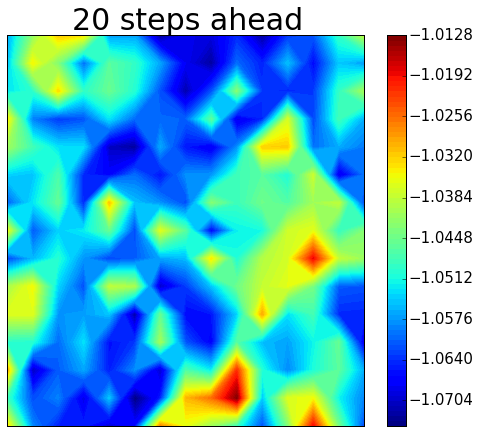

In [53]:
## 5 steps ahead
BO_glasses.n_ahead = 20
loss_ahead2 = BO_glasses.loss_ahead(X).reshape((n_grid,n_grid))

# make the plot
plt.figure(figsize=(8,7))            
plt.contourf(X1, X2,loss_ahead2,100)
plt.title('20 steps ahead',size=30)
plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))
plt.tick_params(axis='both', which='major', labelsize=15)
cbar = plt.colorbar()
cbar.ax.tick_params(axis='both', which='major', labelsize=15)
plt.xticks([])
plt.yticks([])
plt.savefig('20_ahead.pdf',type='pdf',bbox_inches='tight', pad_inches=0.1)

Two main conclusions form the plots:

* Increasing the steps ahead decreases the optimum value of the loss: Makes sense-> the algorithm can visit more locations and the expected min is better.

* Increasing the steps ahead also makes the loss to be flatter and flatter: it is likely to hit a good location irrespective of the initial point so all candidate looks better because of the future chances of the algorithm to be in a good location.
   
Also if we make the number of steps ahead tend to infinite (although we know we are doing this for a finite budget) we would expect the loss to be flat: any location you may visit is equally good since, eventually, in the infinite sequence we will visit the optimum.

Another point of view: with may steps ahead we encourage exploration of the domain, whereas with less evaluation the decisions moves towards finding a 'good' point close to the optimum.